In [23]:
# Imports
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
# Load data
df = pd.read_csv("../results/city_budget_system_frame_partner_all_results.csv")

# Compute allocation proportions
df['partner_alloc'] = df['alloc1'] / (df['alloc0'] + df['alloc1'])
df['self_alloc'] = df['alloc0'] / (df['alloc0'] + df['alloc1'])

# Extract experimental conditions
df['cot'] = df['experiment_id'].str.contains('fiscal_cot')
df['framing'] = df['experiment_id'].str.extract('(give|take|divide)')[0]
df['partner'] = df['experiment_id'].str.extract('(housing|council|nimby)')[0]

# Quick look at the data
print("Dataset shape:", df.shape)
print("\nSample allocations:")
print(df[['model', 'self_alloc', 'partner_alloc', 'framing', 'partner', 'cot']].head())

Dataset shape: (2673, 15)

Sample allocations:
                       model  self_alloc  partner_alloc framing  partner  \
0  claude-3-5-haiku-20241022       0.300          0.700    give  housing   
1  claude-3-5-haiku-20241022       0.200          0.800    give  housing   
2  claude-3-5-haiku-20241022       0.250          0.750    give  housing   
3  claude-3-5-haiku-20241022       0.500          0.500    give  housing   
4  claude-3-5-haiku-20241022       0.500          0.500    give  housing   

     cot  
0  False  
1  False  
2  False  
3  False  
4  False  


In [25]:
# Helper function for statistical tests
def analyze_groups(group1, group2, label1, label2):
    # Mann-Whitney U test
    stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    
    # Effect size (Cohen's d)
    d = (np.mean(group1) - np.mean(group2)) / np.sqrt(
        ((len(group1) - 1) * np.var(group1) + 
         (len(group2) - 1) * np.var(group2)) / 
        (len(group1) + len(group2) - 2)
    )
    
    # Interpret effect size
    if abs(d) < 0.2:
        effect = "negligible"
    elif abs(d) < 0.5:
        effect = "small"
    elif abs(d) < 0.8:
        effect = "medium"
    else:
        effect = "large"
    
    print(f"\n{label1} (n={len(group1)}) vs {label2} (n={len(group2)}):")
    print(f"  Partner allocation: {np.mean(group1)*100:.1f}% vs {np.mean(group2)*100:.1f}%")
    print(f"  Difference: {(np.mean(group1) - np.mean(group2))*100:.1f}% points")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Effect size: {abs(d):.3f} ({effect})")

In [26]:
# Analyze model differences
print("=== Model Comparisons ===")
models = df['model'].unique()

for i, model1 in enumerate(models):
    for model2 in models[i+1:]:
        group1 = df[df['model'] == model1]['partner_alloc']
        group2 = df[df['model'] == model2]['partner_alloc']
        analyze_groups(group1, group2, model1, model2)

=== Model Comparisons ===

claude-3-5-haiku-20241022 (n=720) vs claude-3-5-sonnet-20241022 (n=738):
  Partner allocation: 42.9% vs 78.2%
  Difference: -35.3% points
  p-value: nan
  Effect size: 1.313 (large)

claude-3-5-haiku-20241022 (n=720) vs claude-3-haiku-20240307 (n=702):
  Partner allocation: 42.9% vs 41.6%
  Difference: 1.3% points
  p-value: 0.085089
  Effect size: 0.063 (negligible)

claude-3-5-haiku-20241022 (n=720) vs claude-3-opus-20240229 (n=513):
  Partner allocation: 42.9% vs 84.7%
  Difference: -41.7% points
  p-value: nan
  Effect size: 1.599 (large)

claude-3-5-sonnet-20241022 (n=738) vs claude-3-haiku-20240307 (n=702):
  Partner allocation: 78.2% vs 41.6%
  Difference: 36.6% points
  p-value: nan
  Effect size: 1.528 (large)

claude-3-5-sonnet-20241022 (n=738) vs claude-3-opus-20240229 (n=513):
  Partner allocation: 78.2% vs 84.7%
  Difference: -6.4% points
  p-value: nan
  Effect size: 0.221 (small)

claude-3-haiku-20240307 (n=702) vs claude-3-opus-20240229 (n=513

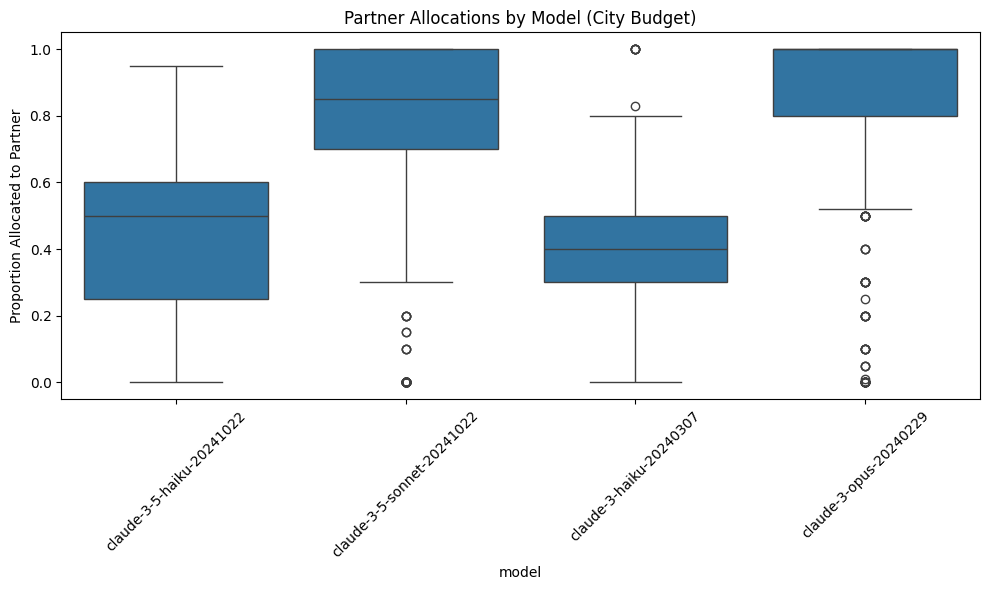

In [27]:
# Visualize model differences
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='model', y='partner_alloc')
plt.title('Partner Allocations by Model (City Budget)')
plt.ylabel('Proportion Allocated to Partner')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== CoT vs NoCoT ===

CoT (n=1269) vs NoCoT (n=1404):
  Partner allocation: 59.6% vs 60.9%
  Difference: -1.3% points
  p-value: nan
  Effect size: 0.040 (negligible)


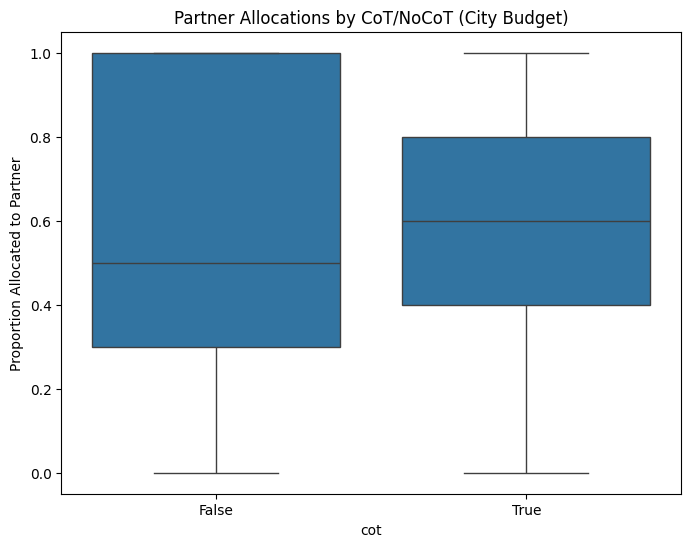

In [28]:
# Analyze CoT differences
print("=== CoT vs NoCoT ===")
cot_group = df[df['cot']]['partner_alloc']
nocot_group = df[~df['cot']]['partner_alloc']
analyze_groups(cot_group, nocot_group, 'CoT', 'NoCoT')

# Visualize CoT differences
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='cot', y='partner_alloc')
plt.title('Partner Allocations by CoT/NoCoT (City Budget)')
plt.ylabel('Proportion Allocated to Partner')
plt.show()

=== Framing Comparisons ===

give (n=885) vs take (n=885):
  Partner allocation: 48.2% vs 72.1%
  Difference: -24.0% points
  p-value: 0.000000
  Effect size: 0.774 (medium)

give (n=885) vs divide (n=903):
  Partner allocation: 48.2% vs 60.6%
  Difference: -12.4% points
  p-value: nan
  Effect size: 0.401 (small)

take (n=885) vs divide (n=903):
  Partner allocation: 72.1% vs 60.6%
  Difference: 11.6% points
  p-value: nan
  Effect size: 0.412 (small)


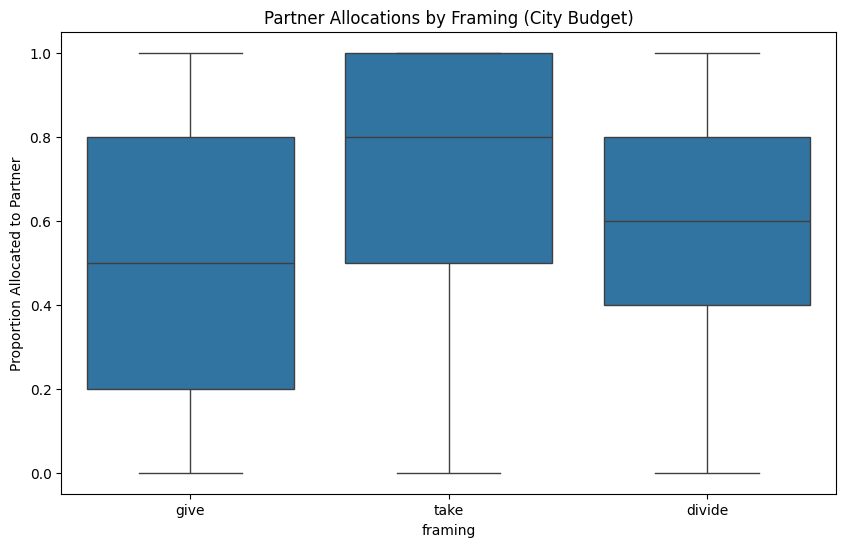

In [29]:
# Analyze framing differences
print("=== Framing Comparisons ===")
framings = df['framing'].unique()

for i, frame1 in enumerate(framings):
    for frame2 in framings[i+1:]:
        group1 = df[df['framing'] == frame1]['partner_alloc']
        group2 = df[df['framing'] == frame2]['partner_alloc']
        analyze_groups(group1, group2, frame1, frame2)

# Visualize framing differences
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='framing', y='partner_alloc')
plt.title('Partner Allocations by Framing (City Budget)')
plt.ylabel('Proportion Allocated to Partner')
plt.show()

=== Partner Comparisons ===

housing (n=849) vs council (n=903):
  Partner allocation: 71.1% vs 61.1%
  Difference: 10.0% points
  p-value: 0.000000
  Effect size: 0.386 (small)

housing (n=849) vs nimby (n=921):
  Partner allocation: 71.1% vs 49.5%
  Difference: 21.6% points
  p-value: nan
  Effect size: 0.689 (medium)

council (n=903) vs nimby (n=921):
  Partner allocation: 61.1% vs 49.5%
  Difference: 11.6% points
  p-value: nan
  Effect size: 0.349 (small)


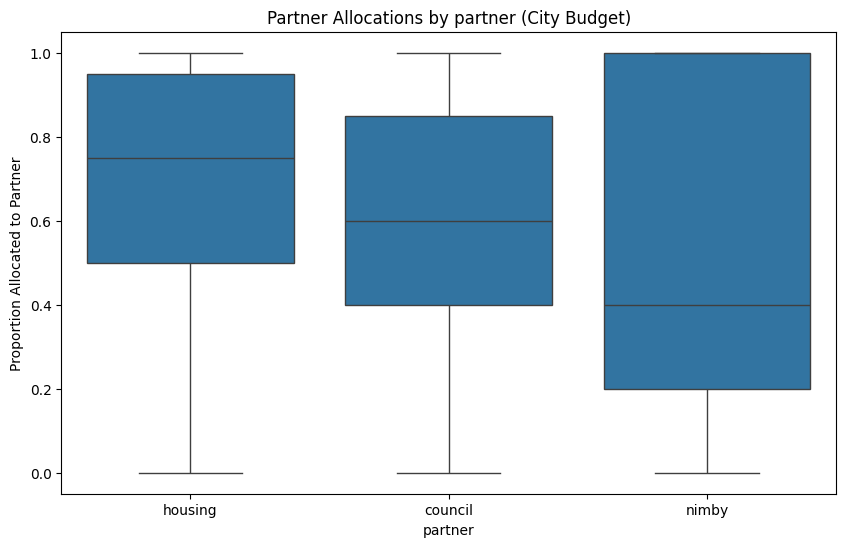

In [30]:
# Analyze partner differences
print("=== Partner Comparisons ===")
partners = df['partner'].unique()

for i, partner1 in enumerate(partners):
    for partner2 in partners[i+1:]:
        group1 = df[df['partner'] == partner1]['partner_alloc']
        group2 = df[df['partner'] == partner2]['partner_alloc']
        analyze_groups(group1, group2, partner1, partner2)

# Visualize partner differences
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='partner', y='partner_alloc')
plt.title('Partner Allocations by partner (City Budget)')
plt.ylabel('Proportion Allocated to Partner')
plt.show()

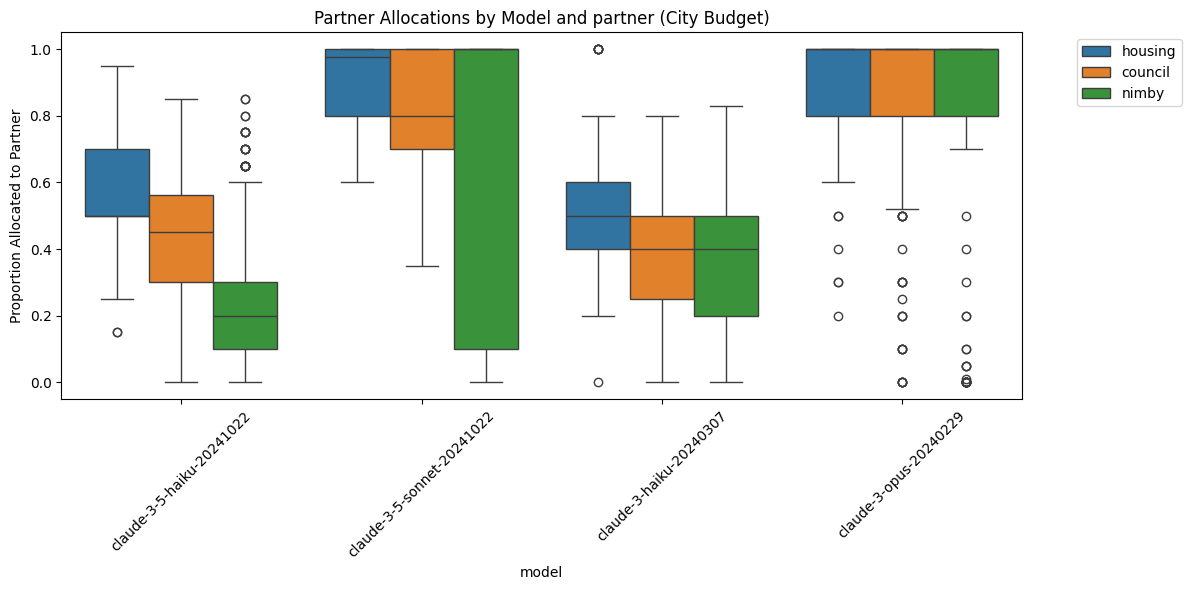

In [31]:
# Look at model-partner interactions
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='model', y='partner_alloc', hue='partner')
plt.title('Partner Allocations by Model and partner (City Budget)')
plt.ylabel('Proportion Allocated to Partner')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

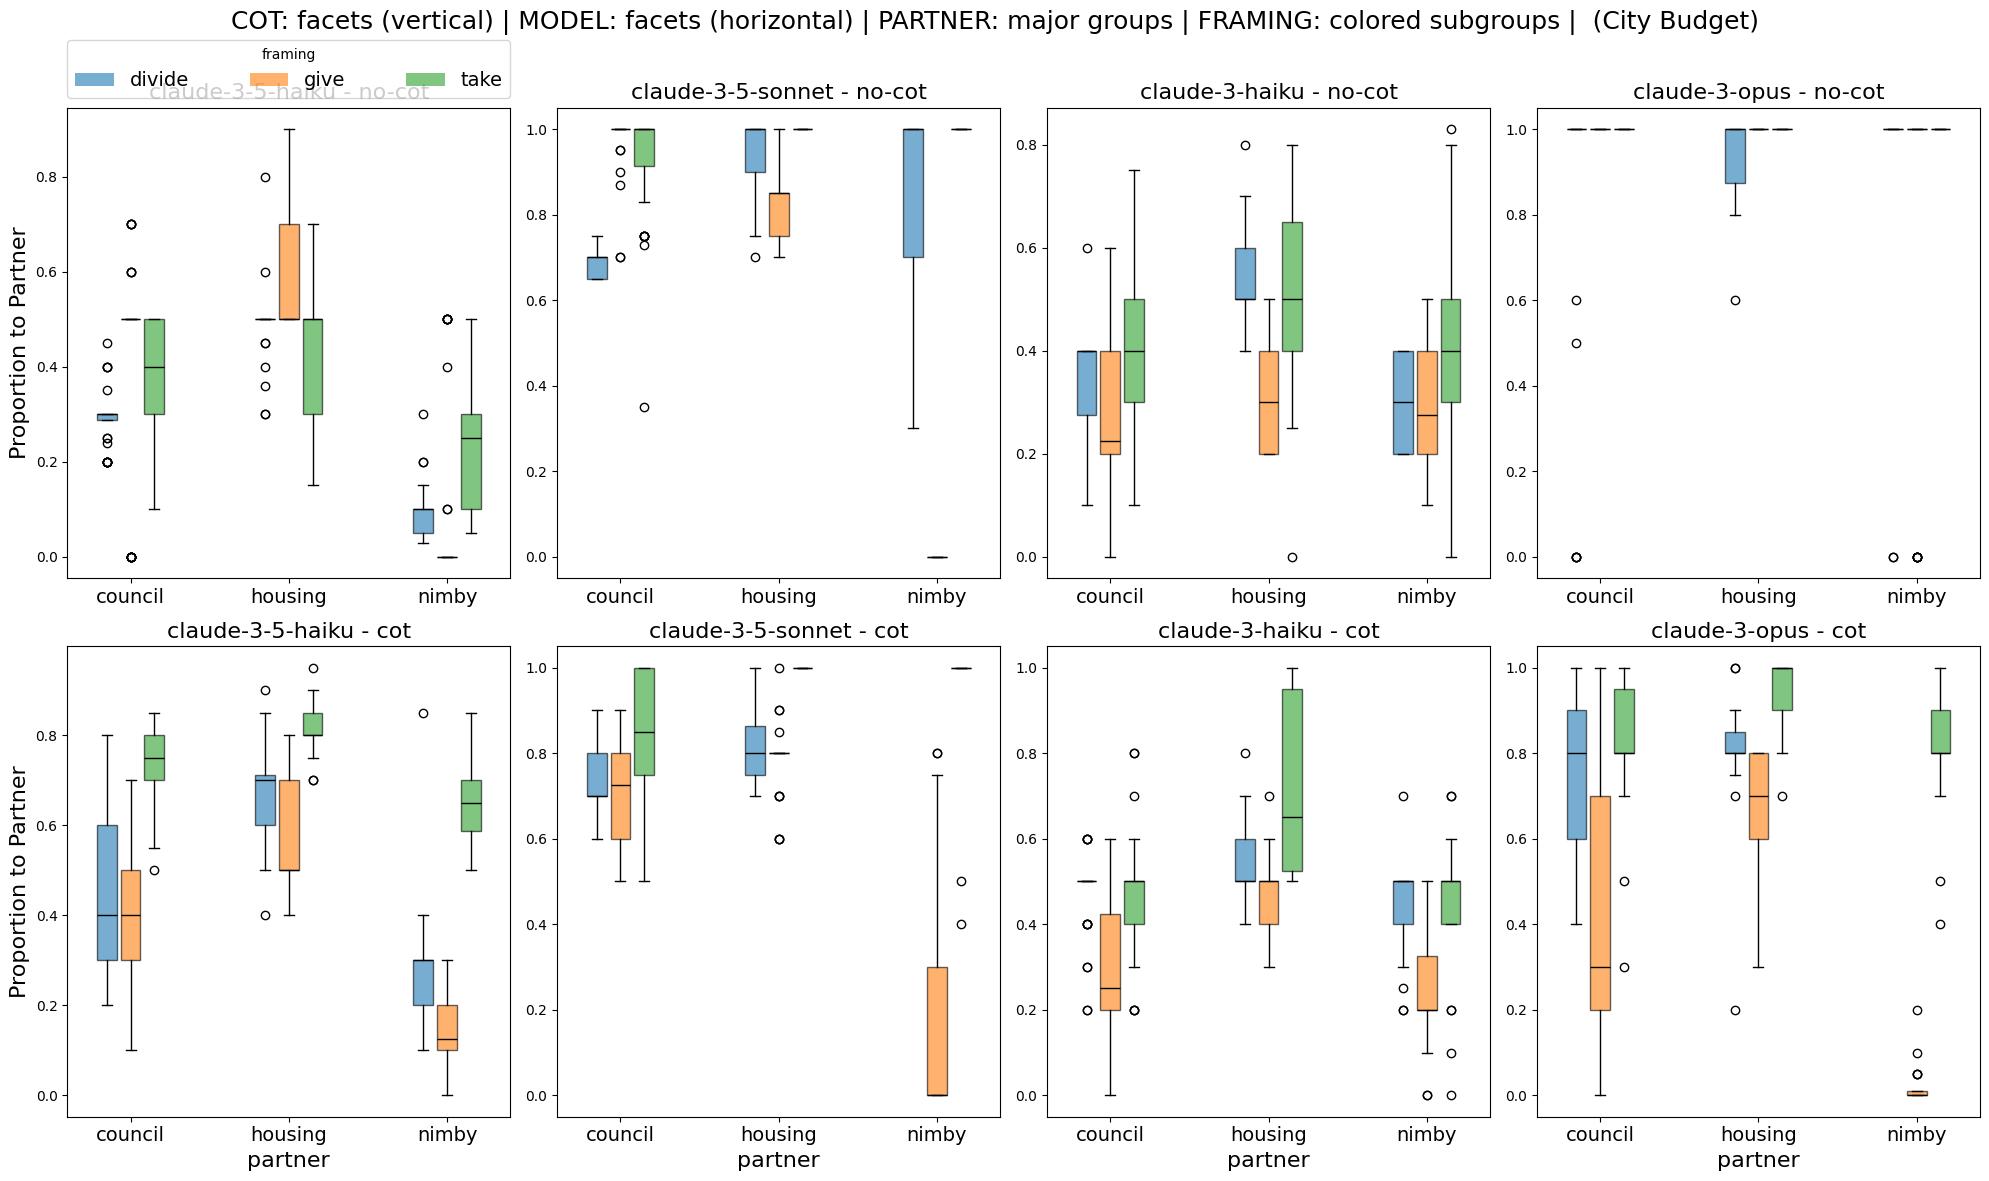

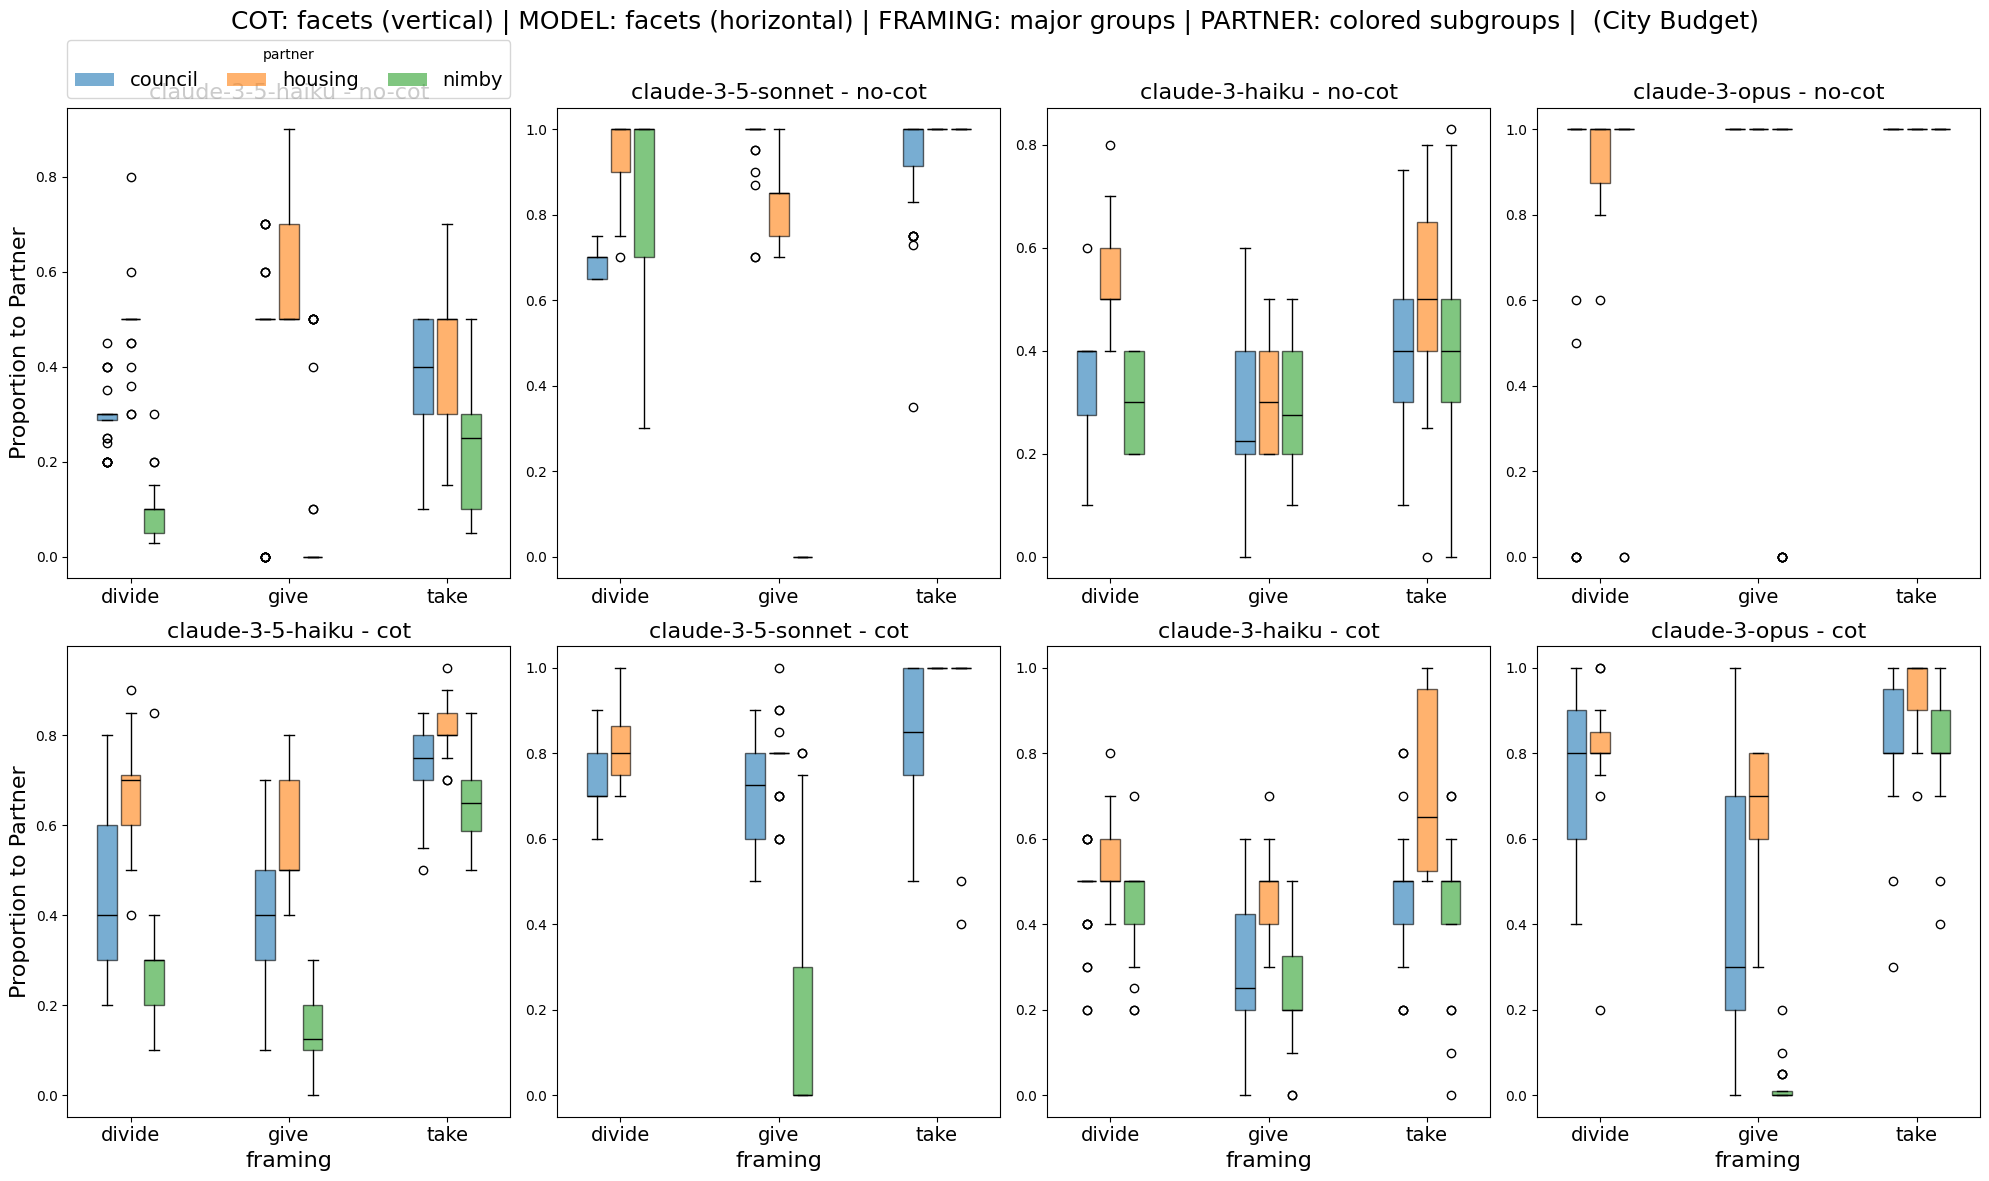

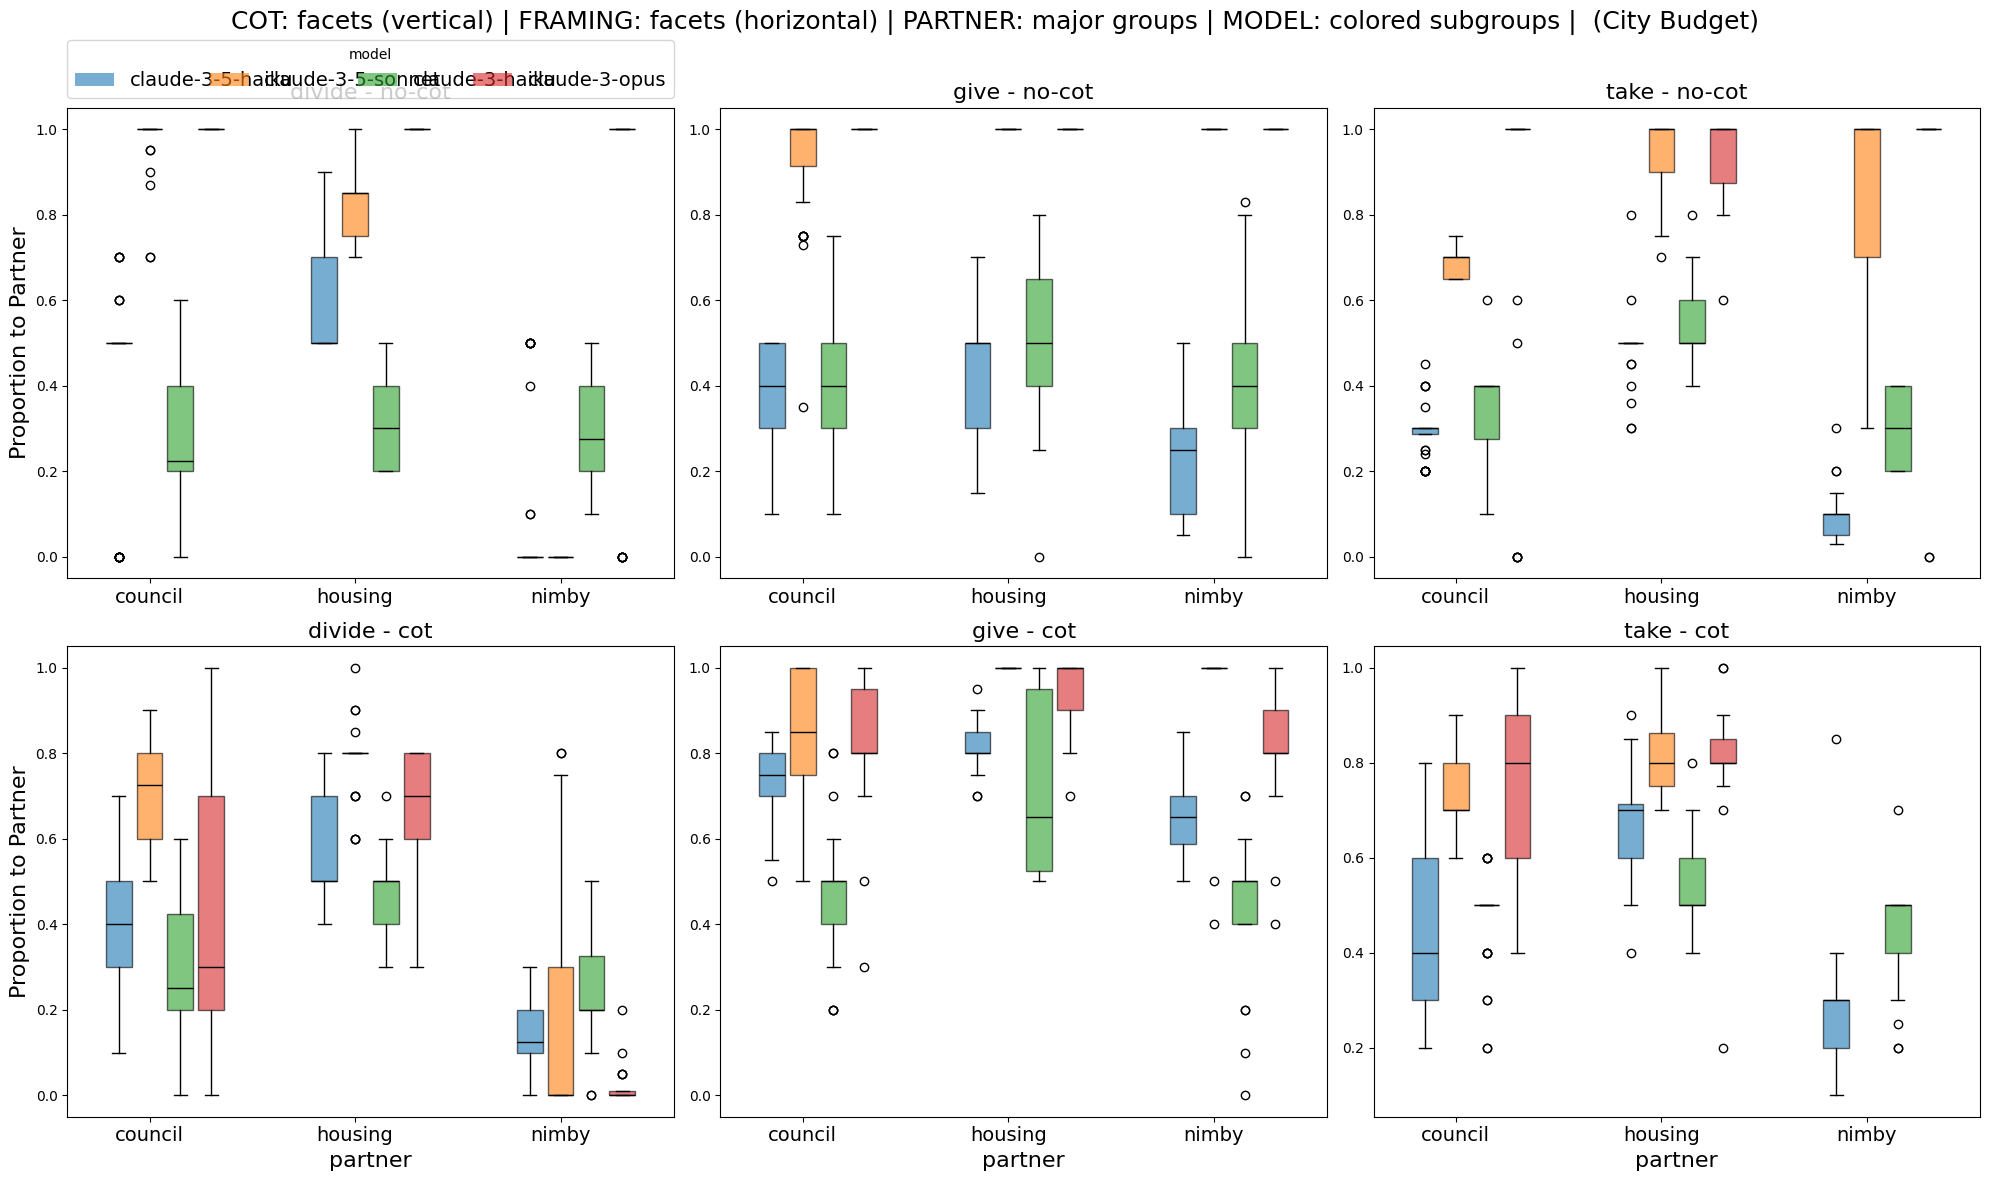

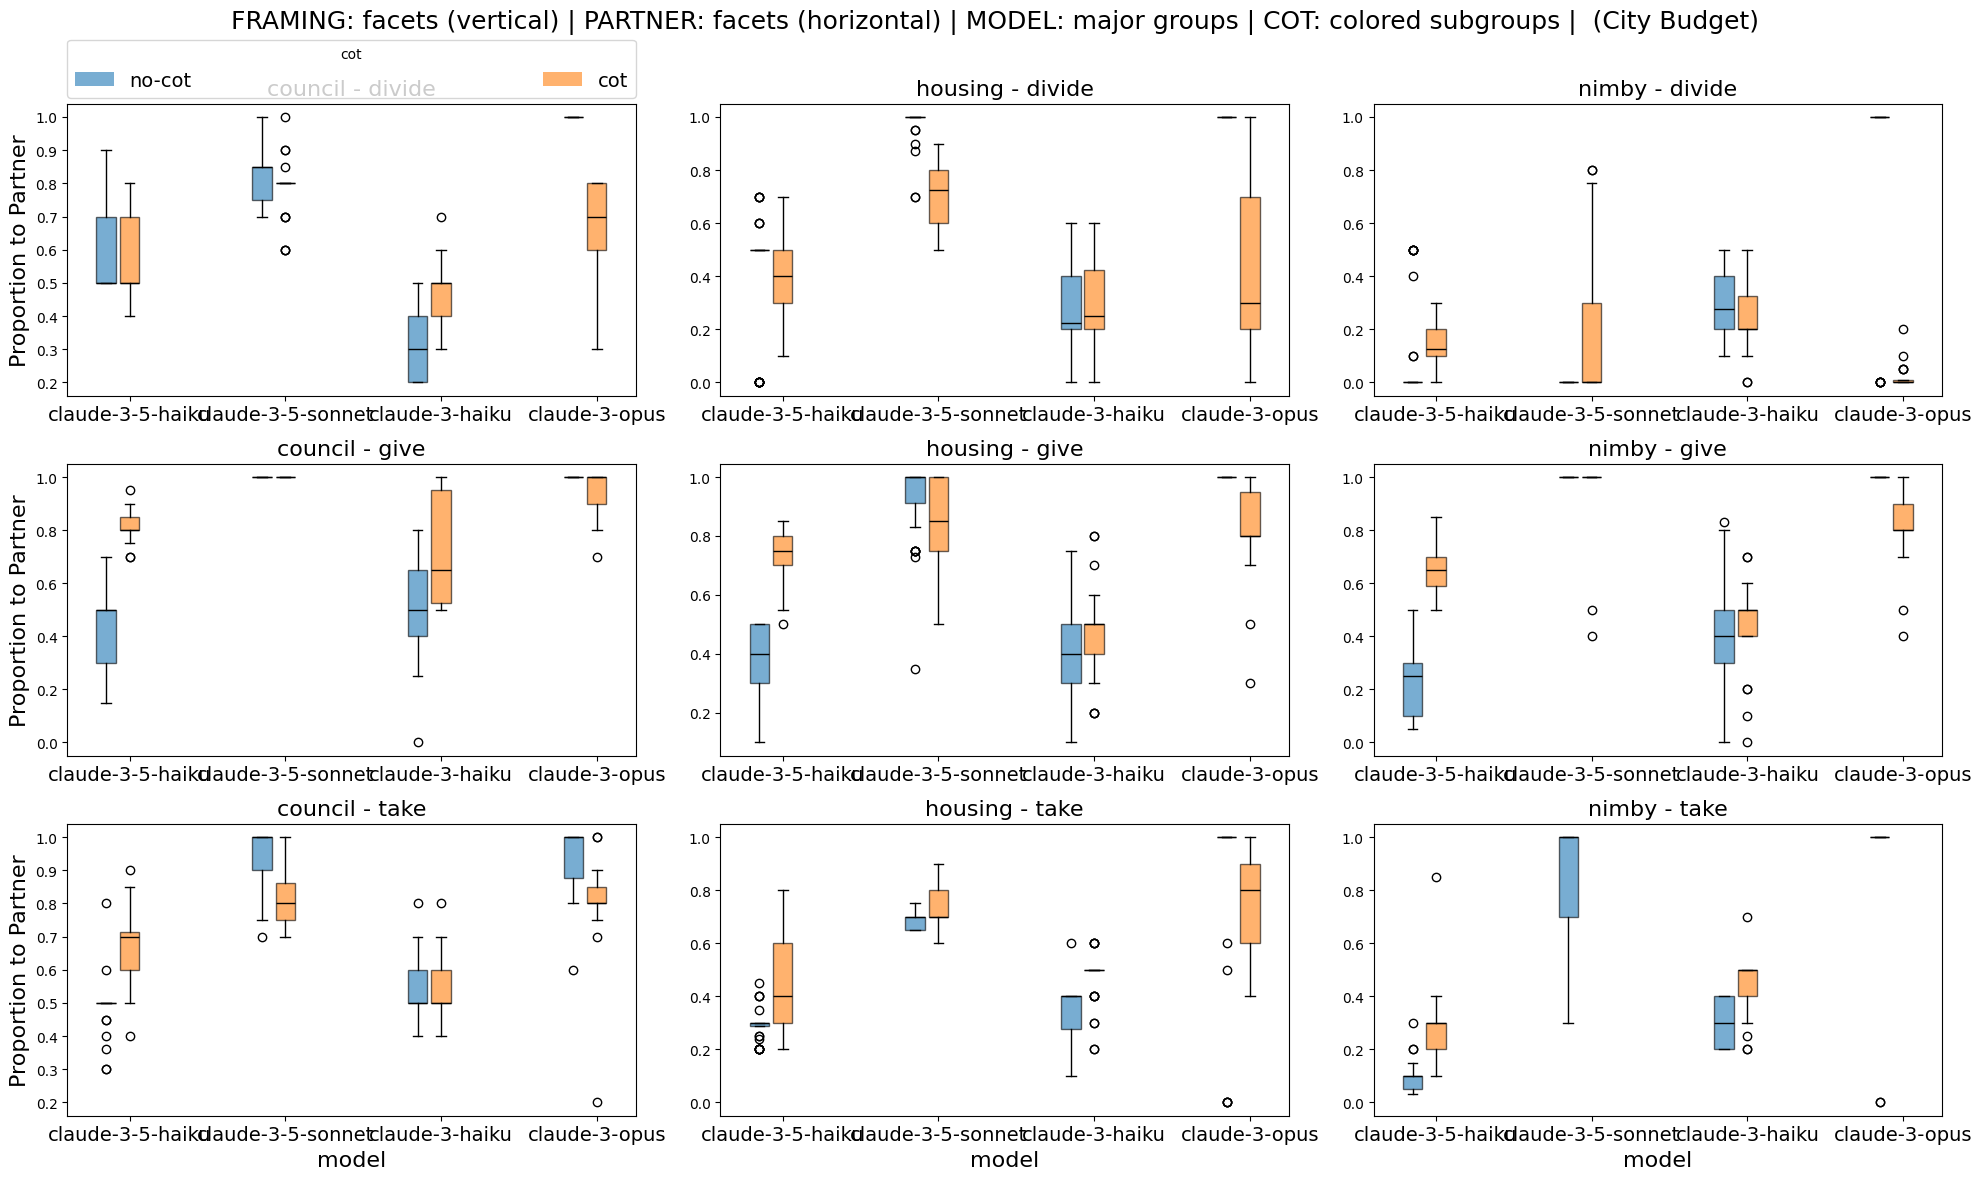

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import rgb2hex
import re

def clean_model_name(name):
    """Remove the trailing -######## from model names"""
    return re.sub(r'-[0-9a-f]{8,}$', '', name)

def clean_label(col, val):
    """Clean up labels for display"""
    if col == 'model':
        return re.sub(r'-[0-9a-f]{8,}$', '', val)
    elif col == 'cot':
        return 'cot' if val else 'no-cot'
    return val

def create_multilevel_boxplot(df, organization, figsize=(20, 12)):
    """
    Create a multi-level boxplot with flexible organization of facets and groups.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The data to plot
    organization : list of str
        List of column names in order of [facet_y, facet_x, major_group, minor_group]
        where minor_group will be represented by color
    figsize : tuple
        Figure size (width, height)
    """
    # Extract the organizational levels
    facet_y, facet_x, major_group, minor_group = organization
    
    # Get unique values for each level and clean model names if present
    uniques = {}
    for col in organization:
        values = sorted(df[col].unique())
        if col == 'model':
            uniques[col] = [clean_model_name(val) for val in values]
        else:
            uniques[col] = values
    
    # Generate enough colors for the minor grouping
    n_colors = len(uniques[minor_group])
    colors = [rgb2hex(plt.cm.tab20(i)) for i in np.linspace(0, 1, n_colors)]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'][:n_colors]
    
    # Create subplot grid
    n_rows = len(uniques[facet_y])
    n_cols = len(uniques[facet_x])
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Convert to 2D array if only one row or column
    if n_rows == 1:
        axs = axs[np.newaxis, :]
    elif n_cols == 1:
        axs = axs[:, np.newaxis]
    
    # Create title based on organization
    title_parts = [
        f"{col.upper()}: facets ({orientation})"
        for col, orientation in [(facet_y, 'vertical'), (facet_x, 'horizontal')]
    ] + [
        f"{major_group.upper()}: major groups",
        f"{minor_group.upper()}: colored subgroups"
    ] + [" (City Budget)"]
    fig.suptitle(" | ".join(title_parts), fontsize=18)  # Increased font size
    
    # For each facet combination
    for i, val_y in enumerate(uniques[facet_y]):
        for j, val_x in enumerate(uniques[facet_x]):
            ax = axs[i, j]
            
            # Filter data for this facet
            # Use original values for filtering
            y_val_orig = df[facet_y].unique()[i]
            x_val_orig = df[facet_x].unique()[j]
            facet_data = df[
                (df[facet_y] == y_val_orig) & 
                (df[facet_x] == x_val_orig)
            ]
            
            # Prepare data for grouped boxplot
            positions = []
            data_points = []
            colors_map = []
            
            # For each major group
            for major_idx, major_val in enumerate(uniques[major_group]):
                # Get original value for filtering if it's a model
                major_val_orig = df[major_group].unique()[major_idx] if major_group == 'model' else major_val
                
                # For each minor group
                for minor_idx, minor_val in enumerate(uniques[minor_group]):
                    # Get original value for filtering if it's a model
                    minor_val_orig = df[minor_group].unique()[minor_idx] if minor_group == 'model' else minor_val
                    
                    mask = (
                        (facet_data[major_group] == major_val_orig) & 
                        (facet_data[minor_group] == minor_val_orig)
                    )
                    data_points.append(facet_data[mask]['partner_alloc'])
                    positions.append(major_idx * 2 + minor_idx * 0.3)
                    colors_map.append(colors[minor_idx])
            
            # Create boxplots
            bplots = ax.boxplot(
                data_points, 
                positions=positions, 
                patch_artist=True,
                medianprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(color='black', markeredgecolor='black'),
                widths=0.25
            )
            
            # Color the boxes
            for patch, color in zip(bplots['boxes'], colors_map):
                patch.set_facecolor(color)
                patch.set_alpha(0.6)
            
            # Customize plot
            # Use cleaned values for display
            # ax.set_title(f"{val_x} - {val_y}")
            ax.set_title(f"{clean_label(facet_x, val_x)} - {clean_label(facet_y, val_y)}", fontsize=16)  # Increased font size
            
            # Only add y-label for leftmost plots
            if j == 0:
                ax.set_ylabel('Proportion to Partner', fontsize=16)  # Increased font size
            
            # Only add x-label for bottom plots
            if i == n_rows - 1:
                ax.set_xlabel(major_group, fontsize=16)  # Increased font size
            
            # Set x-ticks
            ax.set_xticks([p * 2 + 0.3 for p in range(len(uniques[major_group]))])
            # ax.set_xticklabels(uniques[major_group])
            ax.set_xticklabels([clean_label(major_group, val) for val in uniques[major_group]], fontsize=14)  # Increased font size
            
            # Add legend only to first subplot
            if i == 0 and j == 0:
                handles = [plt.Rectangle((0,0),1,1, facecolor=color, alpha=0.6) 
                          for color in colors[:len(uniques[minor_group])]]
                ax.legend(
                    handles, 
                    # uniques[minor_group],
                    [clean_label(minor_group, val) for val in uniques[minor_group]],
                    title=minor_group,
                    bbox_to_anchor=(0, 1.02, 1, 0.2),
                    loc="lower left",
                    mode="expand",
                    borderaxespad=0,
                    ncol=len(uniques[minor_group]),
                    fontsize=14  # Increased font size
                )
    
    plt.tight_layout()
    return fig

# Define all organizations to visualize
organizations = [
    ['cot', 'model', 'partner', 'framing'],  # Original
    ['cot', 'model', 'framing', 'partner'],  # cot > model > frame > partner
    ['cot', 'framing', 'partner', 'model'],  # cot > frame > partner > model
    ['framing', 'partner', 'model', 'cot'],  # frame > partner > model > cot
]

# Generate each variant
for org in organizations:
    fig = create_multilevel_boxplot(df, org)
    plt.show()

In [33]:
# Create summary statistics for all subgroups
summary_stats = df.groupby(['cot', 'partner', 'framing', 'model'])['partner_alloc'].agg([
    'count',
    'mean',
    'std'
]).reset_index()

# Add 95% confidence intervals
summary_stats['ci'] = 1.96 * summary_stats['std'] / np.sqrt(summary_stats['count'])

# Create a single dataframe with all subgroup conditions
all_stats = summary_stats.sort_values(['cot', 'partner', 'framing', 'model'])

# Format for printing
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(all_stats.to_string(index=False))

# Save to csv
all_stats.to_csv('../results/city_budget_all_stats.csv', index=False)

  cot partner framing                      model  count  mean   std    ci
False council  divide  claude-3-5-haiku-20241022     40 0.291 0.058 0.018
False council  divide claude-3-5-sonnet-20241022     40 0.687 0.027 0.008
False council  divide    claude-3-haiku-20240307     40 0.340 0.101 0.031
False council  divide     claude-3-opus-20240229     40 0.878 0.313 0.097
False council    give  claude-3-5-haiku-20241022     40 0.415 0.235 0.073
False council    give claude-3-5-sonnet-20241022     40 0.977 0.070 0.022
False council    give    claude-3-haiku-20240307     40 0.293 0.130 0.040
False council    give     claude-3-opus-20240229     40 1.000 0.000 0.000
False council    take  claude-3-5-haiku-20241022     40 0.372 0.119 0.037
False council    take claude-3-5-sonnet-20241022     40 0.934 0.133 0.041
False council    take    claude-3-haiku-20240307     40 0.392 0.131 0.041
False council    take     claude-3-opus-20240229     40 1.000 0.000 0.000
False housing  divide  claude-3-5-haik

In [34]:
# Let's also look at the most extreme differences between subgroups
def get_subgroup_allocs(data, partner, frame, model):
    mask = (
        (data['partner'] == partner) & 
        (data['framing'] == frame) & 
        (data['model'] == model)
    )
    return data[mask]['partner_alloc']

# Compare all subgroup pairs within each CoT condition
for is_cot in [True, False]:
    print(f"\n{'='*20} {'CoT' if is_cot else 'NoCoT'} {'='*20}")
    data = df[df['cot'] == is_cot]
    
    partners = data['partner'].unique()
    frames = data['framing'].unique()
    models = data['model'].unique()
    
    # Find most extreme differences
    comparisons = []
    for p1 in partners:
        for f1 in frames:
            for m1 in models:
                group1 = get_subgroup_allocs(data, p1, f1, m1)
                if len(group1) == 0:
                    continue
                    
                for p2 in partners:
                    for f2 in frames:
                        for m2 in models:
                            if p1 == p2 and f1 == f2 and m1 == m2:
                                continue
                                
                            group2 = get_subgroup_allocs(data, p2, f2, m2)
                            if len(group2) == 0:
                                continue
                                
                            diff = np.mean(group1) - np.mean(group2)
                            comparisons.append({
                                'group1': f"{p1}-{f1}-{m1}",
                                'group2': f"{p2}-{f2}-{m2}",
                                'diff': diff,
                                'mean1': np.mean(group1),
                                'mean2': np.mean(group2)
                            })
    
    # Sort by absolute difference and show top 5
    comparisons.sort(key=lambda x: abs(x['diff']), reverse=True)
    print("\nLargest differences between subgroups:")
    for i, comp in enumerate(comparisons[:5], 1):
        print(f"\n{i}. {comp['group1']} vs {comp['group2']}")
        print(f"   {comp['mean1']*100:.1f}% vs {comp['mean2']*100:.1f}%")
        print(f"   Difference: {comp['diff']*100:.1f}% points")


==================== CoT ====================

Largest differences between subgroups:

1. housing-take-claude-3-5-sonnet-20241022 vs nimby-give-claude-3-opus-20240229
   100.0% vs 2.2%
   Difference: 97.8% points

2. nimby-give-claude-3-opus-20240229 vs housing-take-claude-3-5-sonnet-20241022
   2.2% vs 100.0%
   Difference: -97.8% points

3. nimby-give-claude-3-opus-20240229 vs nimby-take-claude-3-5-sonnet-20241022
   2.2% vs 98.1%
   Difference: -95.9% points

4. nimby-take-claude-3-5-sonnet-20241022 vs nimby-give-claude-3-opus-20240229
   98.1% vs 2.2%
   Difference: 95.9% points

5. housing-take-claude-3-opus-20240229 vs nimby-give-claude-3-opus-20240229
   92.9% vs 2.2%
   Difference: 90.7% points

==================== NoCoT ====================

Largest differences between subgroups:

1. housing-give-claude-3-opus-20240229 vs nimby-give-claude-3-5-sonnet-20241022
   100.0% vs 0.0%
   Difference: 100.0% points

2. housing-take-claude-3-5-sonnet-20241022 vs nimby-give-claude-3-5-s